# Long Short Term Memory (LSTM)

## Problem with standard recurrent nets

Standard recurrent nets, during training, will have gradients that either vanish or explode, depending on the size of the largest eigenvalue of the weight matrix. Illustration of a vanishing gradient: 

<img src="vanishing_gradient_50.png">

LSTMs and some other types of *gated* recurrent nets (GRUs among others) don't suffer from this problem. Here is how gradient would propagate through time with an LSTM:

<img src="lstm_gradient_50.png">

## Structure of LSTM

A single LSTM unit looks like this:

<img src="lstm_diagram_50.png">

One could have multiple LSTM units layed out in parallel, or LSTM units on top of LSTM units, or even bidirectional LSTMs. Here is an example of a parallel layout:

<img src="lstm_multiple_units_50.png">

## Theano Implementation

After http://christianherta.de/lehre/dataScience/machineLearning/neuralNetworks/LSTM.php

In [72]:
import numpy as np
import theano
import theano.tensor as T

dtype=theano.config.floatX

<img src="LSTM_definition_corrected_50.png">

In [73]:
# squashing of the gates should result in values between 0 and 1
# therefore we use the logistic function
sigma = lambda x: 1 / (1 + T.exp(-x))

# for the other activation function we use the tanh
act = T.tanh

# sequences: x_t
# prior results: h_tm1, c_tm1
# non-sequences: W_xi, W_hi, W_ci, b_i, W_xf, W_hf, W_cf, b_f, W_xc, W_hc, b_c, 
#                W_xy, W_hy, W_cy, b_y
def one_lstm_step(x_t, h_tm1, c_tm1, W_xi, W_hi, W_ci, b_i, W_xf, W_hf, W_cf, 
                  b_f, W_xc, W_hc, b_c, W_xy, W_ho, W_cy, b_o, W_hy, b_y):
    i_t = sigma(theano.dot(x_t, W_xi) + theano.dot(h_tm1, W_hi) + \
                theano.dot(c_tm1, W_ci) + b_i)
    f_t = sigma(theano.dot(x_t, W_xf) + theano.dot(h_tm1, W_hf) + \
                theano.dot(c_tm1, W_cf) + b_f)
    c_t = f_t * c_tm1 + i_t * act(theano.dot(x_t, W_xc) + 
                                  theano.dot(h_tm1, W_hc) + b_c) 
    o_t = sigma(theano.dot(x_t, W_xo)+ theano.dot(h_tm1, W_ho) + 
                theano.dot(c_t, W_co)  + b_o)
    h_t = o_t * act(c_t)
    y_t = sigma(theano.dot(h_t, W_hy) + b_y) 
    return [h_t, c_t, y_t]

In [74]:
def sample_weights(sizeX, sizeY):
    values = np.ndarray([sizeX, sizeY], dtype=dtype)
    for dx in xrange(sizeX):
        values[dx,:] = np.random.uniform(low=-1., high=1., size=(sizeY,))
    _, svs, _ = np.linalg.svd(values)
    #svs[0] is the largest singular value                      
    values = values / svs[0]
    return values  

<img src="lstm_pooling.png">

In [75]:
n_in = 7 # for embedded reber grammar
n_hidden = n_i = n_c = n_o = n_f = 10
n_y = 7 # for embedded reber grammar

# initialize weights
# i_t and o_t should be "open" or "closed"
# f_t should be "open" (don't forget at the beginning of training)
# we try to archive this by appropriate initialization of the corresponding biases 

W_xi = theano.shared(sample_weights(n_in, n_i))  
W_hi = theano.shared(sample_weights(n_hidden, n_i))  
W_ci = theano.shared(sample_weights(n_c, n_i))  
b_i = theano.shared(np.cast[dtype](np.random.uniform(-0.5,.5,size = n_i)))
W_xf = theano.shared(sample_weights(n_in, n_f)) 
W_hf = theano.shared(sample_weights(n_hidden, n_f))
W_cf = theano.shared(sample_weights(n_c, n_f))
b_f = theano.shared(np.cast[dtype](np.random.uniform(0, 1.,size = n_f)))
W_xc = theano.shared(sample_weights(n_in, n_c))  
W_hc = theano.shared(sample_weights(n_hidden, n_c))
b_c = theano.shared(np.zeros(n_c, dtype=dtype))
W_xo = theano.shared(sample_weights(n_in, n_o))
W_ho = theano.shared(sample_weights(n_hidden, n_o))
W_co = theano.shared(sample_weights(n_c, n_o))
b_o = theano.shared(np.cast[dtype](np.random.uniform(-0.5,.5,size = n_o)))
W_hy = theano.shared(sample_weights(n_hidden, n_y))
b_y = theano.shared(np.zeros(n_y, dtype=dtype))

c0 = theano.shared(np.zeros(n_hidden, dtype=dtype))
h0 = T.tanh(c0)

params = [W_xi, W_hi, W_ci, b_i, W_xf, W_hf, W_cf, b_f, W_xc, W_hc, b_c,
          W_xo, W_ho, W_co, b_o, W_hy, b_y, c0]

In [76]:
#first dimension is time

#input 
v = T.matrix(dtype=dtype)

# target
target = T.matrix(dtype=dtype)

In [77]:
# hidden and outputs of the entire sequence
[h_vals, _, y_vals], _ = theano.scan(
    fn=one_lstm_step, 
    sequences = dict(input=v, taps=[0]), 
    outputs_info = [h0, c0, None ], # corresponds to return type of fn
    non_sequences = [W_xi, W_hi, W_ci, b_i, W_xf, W_hf, W_cf, b_f, W_xc, W_hc,
                     b_c, W_xo, W_ho, W_co, b_o, W_hy, b_y]
)

In [78]:
# cross-entropy cost
cost = -T.mean(target * T.log(y_vals) + (1.- target) * T.log(1. - y_vals))
learning_rate = theano.shared(np.cast[dtype](.1))

In [79]:
gparams = []
for param in params:
    gparam = T.grad(cost, param)
    gparams.append(gparam)

updates=[]
for param, gparam in zip(params, gparams):
    updates.append((param, param - gparam * learning_rate))

## Learning Reber Grammar

Simple version of Reber grammar:

<img src="reberGrammar.png">

Embedded version:

<img src="embeddedReberGrammar.png">

In [80]:
import reberGrammar
train_data = reberGrammar.get_n_embedded_examples(100)

In [81]:
learn_rnn_fn = theano.function(inputs=[v, target],
                               outputs=cost,
                               updates=updates)

In [ ]:
nb_epochs=200
train_errors = np.ndarray(nb_epochs)

def train_rnn(train_data):      
    for epoch in range(nb_epochs):
        error = 0.0
        for j in range(len(train_data)):  
            index = np.random.randint(0, len(train_data))
            i, o = train_data[index]
            train_cost = learn_rnn_fn(i, o)
            error += train_cost
        train_errors[epoch] = error 
        print epoch, error

train_rnn(train_data)

(0.0, 50)

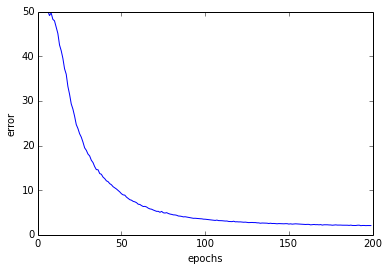

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(np.arange(nb_epochs), train_errors, 'b-')
plt.xlabel('epochs')
plt.ylabel('error')
plt.ylim(0., 50)

## Predictions

In [63]:
predictions = theano.function(inputs = [v], outputs = y_vals)
test_data = reberGrammar.get_n_embedded_examples(10)

def print_out(test_data):
    for i, o in test_data:
        p = predictions(i)
        print o[-2] # target
        print p[-2] # prediction
        print 
print_out(test_data)

[ 0.  1.  0.  0.  0.  0.  0.]
[  1.49718358e-03   5.11488557e-01   2.24089254e-05   2.31526319e-05
   4.82351184e-01   1.14407670e-03   4.51986343e-02]

[ 0.  0.  0.  0.  1.  0.  0.]
[  1.49719242e-03   4.76992846e-01   2.67206706e-05   2.75313341e-05
   4.68519747e-01   9.89855267e-04   4.08085883e-02]

[ 0.  1.  0.  0.  0.  0.  0.]
[  1.79453695e-03   5.27297914e-01   2.28836398e-05   2.36722208e-05
   5.08574784e-01   1.02745695e-03   4.42106985e-02]

[ 0.  1.  0.  0.  0.  0.  0.]
[  2.36487761e-03   5.48388064e-01   2.36356482e-05   2.45287374e-05
   5.39140880e-01   8.58101412e-04   4.38702144e-02]

[ 0.  0.  0.  0.  1.  0.  0.]
[  1.54337706e-03   4.81554449e-01   2.67334453e-05   2.75382135e-05
   4.72645819e-01   9.75941017e-04   4.06297147e-02]

[ 0.  0.  0.  0.  1.  0.  0.]
[  1.57485087e-03   4.65496391e-01   2.74381327e-05   2.82618166e-05
   4.68997151e-01   9.57042444e-04   4.19592336e-02]

[ 0.  0.  0.  0.  1.  0.  0.]
[  1.52073987e-03   4.54384089e-01   2.78926527e-05 